# Calculate One-Day NDVI of Enschede

Import required libraries

In [1]:
# Import necessary libraries
import pystac_client
import odc.stac
import dask.distributed
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import box

Search raster iamagery using STAC catalogue

In [10]:
# Define the area of interest (Enschede, Netherlands)
aoi = [6.869888,52.208238,6.914263,52.230270]

# Set the date range
date_range = ["2023-06-01","2023-06-02"]

# Connect to the Earth Search STAC API
catalog = pystac_client.Client.open("https://earth-search.aws.element84.com/v1")

# Search for Sentinel-2 imagery
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=aoi,
    datetime=date_range,
    query={"eo:cloud_cover": {"lt": 50}}
)

items = search.item_collection()
print(f"Found {len(items)} items")

Found 2 items


Setting the local Dask client. Optionally you can use existing Dask Distributed.

In [ ]:
# Connect to existing Dask cluster
# client = dask.distributed.Client("tcp://localhost:8786")
# Set up a local Dask cluster
client = dask.distributed.Client()
print(client)

<Client: 'tcp://127.0.0.1:64015' processes=4 threads=8, memory=16.00 GiB>


Load all imagery to make a mosaic. Group by solar day.

In [32]:
# Define the bands we want to load
bands = ["red", "nir"]

# Resolution level (in meter)
resolution = 10

# Load the data using odc-stac
ds = odc.stac.load(
    items,
    bands=bands,
    chunks={"y": 5964, "x": 6378, "time": 1},
    groupby="solar_day",
    # resolution=resolution,
)

Show sample data structure

In [33]:
ds.red

<xarray.DataArray 'red' (time: 1, y: 11928, x: 12755)> Size: 304MB
dask.array<red, shape=(1, 11928, 12755), dtype=uint16, chunksize=(1, 5964, 6378), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 95kB 5.809e+06 5.809e+06 ... 5.69e+06 5.69e+06
  * x            (x) float64 102kB 7e+05 7e+05 7e+05 ... 8.275e+05 8.275e+05
    spatial_ref  int32 4B 32631
  * time         (time) datetime64[ns] 8B 2023-06-01T10:46:39.702000
Attributes:
    nodata:   0

Convert into `float32` and handle no-data value

In [38]:
nodata = 0

ds = ds.where(ds != nodata).astype('float32')

In [39]:
ds.red

<xarray.DataArray 'red' (time: 1, y: 11928, x: 12755)> Size: 609MB
dask.array<where, shape=(1, 11928, 12755), dtype=float32, chunksize=(1, 5964, 6378), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 95kB 5.809e+06 5.809e+06 ... 5.69e+06 5.69e+06
  * x            (x) float64 102kB 7e+05 7e+05 7e+05 ... 8.275e+05 8.275e+05
    spatial_ref  int32 4B 32631
  * time         (time) datetime64[ns] 8B 2023-06-01T10:46:39.702000
Attributes:
    nodata:   0

Calculate NDVI value

In [40]:
# Calculate NDVI
ds["ndvi"] = (ds.nir - ds.red) / (ds.nir + ds.red)

In [ ]:
# Do real calculation for NDVI
ds["ndvi"] = ds.ndvi.persist()

<xarray.DataArray 'ndvi' (time: 1, y: 11928, x: 12755)> Size: 609MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.8218074 , 0.67290306, 0.5909301 , ...,        nan,
                nan,        nan],
        [0.83877015, 0.7066501 , 0.5860071 , ...,        nan,
                nan,        nan],
        [0.81117827, 0.688528  , 0.5840345 , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 95kB 5.809e+06 5.809e+06 ... 5.69e+06 5.69e+06
  * x            (x) float64 102kB 7e+05 7e+05 7e+05 ... 8.275e+05 8.275e+05
    spatial_ref  int32 4B 32631
  * time         (time) datetime64[ns] 8B 2023-06-01T10:46:39.702000

Store the calculation result as TIF file

In [42]:
# Save the NDVI result to a GeoTIFF file
ds.ndvi.rio.to_raster("enschede_ndvi.tif", dtype="float32")
print("NDVI saved to 'enschede_ndvi.tif'")

NDVI saved to 'enschede_ndvi.tif'


Plot the result

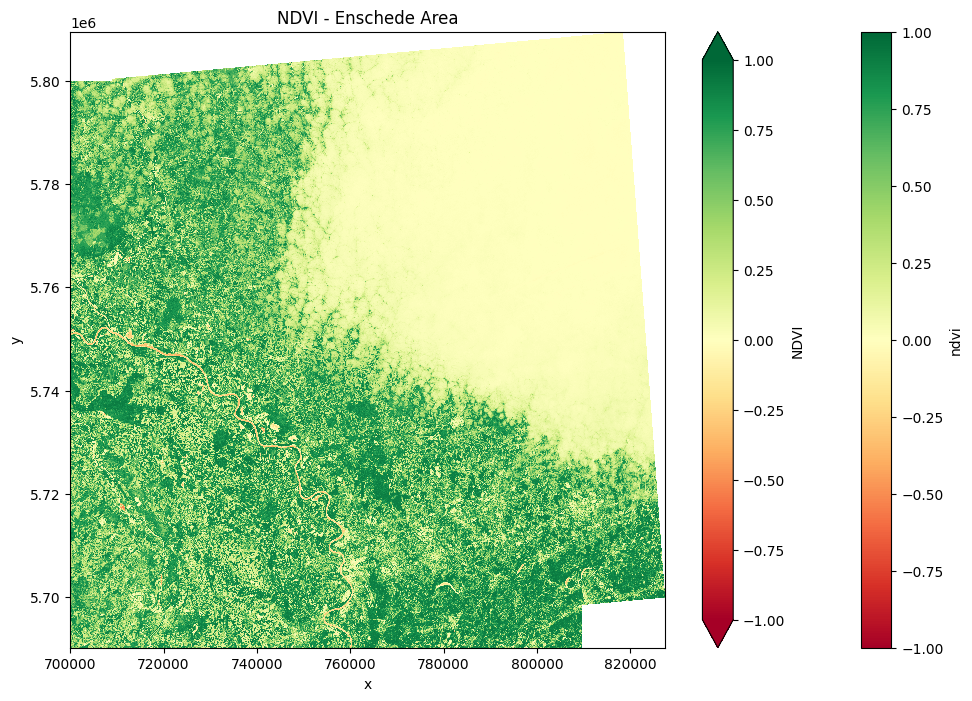

In [44]:
import numpy as np
from matplotlib.colors import ListedColormap

# Create a custom colormap with white for NaN values
cmap = plt.get_cmap('RdYlGn').copy()
cmap.set_bad('white')

ndvi_result = rioxarray.open_rasterio("enschede_ndvi.tif")

# Plot the NDVI
fig, ax = plt.subplots(figsize=(12, 8))
im = ndvi_result.plot(ax=ax, cmap=cmap, vmin=-1, vmax=1)
ax.set_title("NDVI - Enschede Area")

# Add colorbar
cbar = plt.colorbar(im, ax=ax, extend='both')
cbar.set_label('NDVI')

plt.show()